# Link Functions, Logistic Regression, and Advanced AB Testing

**Current Status**: WIP Presentation ready notebook

**Insert picture of a video game store**

Congratulations, in this lesson we are all data scientists at a video game shop. Our job is to help sell more video games. You have all sorts of data on customers and your boss wants to know who to market to. But before we get ahead of ourselves lets talk through the over vi

## Bayesian AB Test
* Revisit the basic Bayesian AB test
* Estimate probability of a potential customer converting


## Regression on Age
* How can we include a continuous variable into our analysis
* Various approaches
  * And why they don't work

## Generalizing linear models with link functions
* The **most** important concept of this course  
  * The most useful transformation

## "A Infinite Testing" with Generalized Linear Models
* Use our generalized linear modeling capability to incorporate age

## Case Study: U.S.A Election Voting
* How does voter preference chance with age and party

In [31]:
import bambi as bmb
from bambi import plots
import arviz as az
from scipy import stats
from scipy import special
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import seaborn as sns
import statsmodels


plt.style.use('intuitivebayes.mplstyle')
FIGSIZE = (16, 8)
SEED=0

rng = np.random.default_rng(0)

# Hidden Section: Generate data
**Hello students**

Welcome to the hidden section where we generate the data. We've included this in the notebook purposefully so you can use it to aid your learnings. Simulation is an important tool because

* During learning you can create new scenarios to have an infinite amount of practice data
* During EDA you can use simulation to see what functional
* Check if your models are correctly specified, especially complex models, by simulating data and seeing if you can recover the parameters



In [2]:
samples = 1000

# 1 indicates likes videogames
likes_videogames_bool = stats.bernoulli(p=.5).rvs(samples)
like_videogames_categorical = ["No" if x == 0 else "Yes" for x in likes_videogames_bool]

# Age
age = stats.randint(low=18, high=60).rvs(samples).astype(float)

df = pd.DataFrame({"age":age,
                   "likes_videogames":like_videogames_categorical,
                   "likes_videogames_bool":likes_videogames_bool}).sort_values("age")
df.head()

,age,likes_videogames,likes_videogames_bool
631,18.0,No,0
852,18.0,No,0
926,18.0,Yes,1
302,18.0,No,0
50,18.0,No,0


## Simulate our data
Unfortunately there are differing names for the sigmoid function in particular
* logistic (or logistic sigmoid)
* expit

Scipy uses the name expit. Since we use scipy in this course we'll use their naming so you learn both, and also can find the documentation for the code

In [3]:
special.expit(3)

0.9525741268224334

In [4]:
# Parameters of model
intercept = 1
coeff_age = -0.1
coeff_likes_videogames = 2

# Construction of mean p_convert
y = intercept + coeff_age * df["age"] + coeff_likes_videogames * df["likes_videogames_bool"]

# Convert the continuous value to 0 1 bounded
# This is the link function
p_convert = special.expit(y)

# Simulate actual conversions. Rememver a prob of .99 doesn't guarantee someone will convert!
# To see that look at the graph below
converted_bool = stats.bernoulli(p=p_convert).rvs(random_state=rng)

df["p_convert"] = p_convert
df["converted_bool"] = converted_bool
df["converted"] = [{1:"Yes", 0:"No"}[outcome] for outcome in converted_bool]
df.head()

,age,likes_videogames,likes_videogames_bool,p_convert,converted_bool,converted
631,18.0,No,0,0.310026,0,No
852,18.0,No,0,0.310026,0,No
926,18.0,Yes,1,0.768525,1,Yes
302,18.0,No,0,0.310026,0,No
50,18.0,No,0,0.310026,1,Yes


## Logistic curves

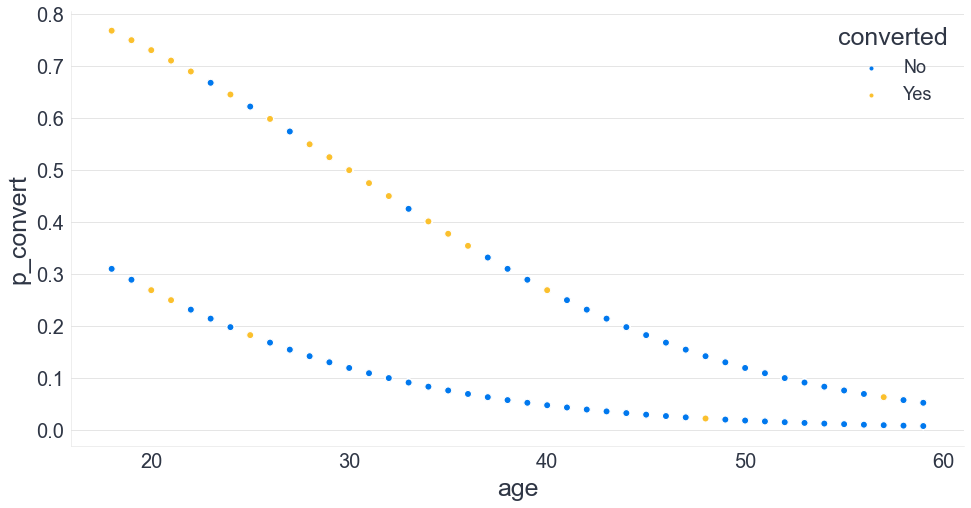

In [5]:
fig, ax = plt.subplots(figsize=FIGSIZE)
sns.scatterplot(x="age", y="p_convert", hue="converted", data=df, ax=ax, s=200);

In [6]:
customers_table = (df.drop("p_convert", axis=1).sample(frac=1, random_state=5).reset_index()
                          [["age", "likes_videogames", "converted", "likes_videogames_bool", "converted_bool"]])
customers_table.head(10)

,age,likes_videogames,converted,likes_videogames_bool,converted_bool
0,41.0,No,No,0,0
1,39.0,Yes,Yes,1,1
2,27.0,No,No,0,0
3,18.0,No,No,0,0
4,30.0,Yes,Yes,1,1
5,45.0,No,No,0,0
6,45.0,Yes,No,1,0
7,49.0,Yes,Yes,1,1
8,27.0,No,Yes,0,1
9,48.0,Yes,No,1,0


# Bayesian AB Test 
The statistics test that everyone loves

## A conversation with your boss


### _"Take a look at our website checkout data._


### _I want to know which customers are most likely to convert so we can focus our marketing efforts on them_

Your boss comes to you with a question, a question that basically every data scientist will get asked in their career. Given a new feature, or some properties about the customer, which are most likely to convert?

Now you're stressed out. You need to turn our results fast. Better get to it

### *Oh and I want the results by the end of the day. I have a meeting with the CEO"*

## Customer data

In [7]:
customers_table.head(10)

,age,likes_videogames,converted,likes_videogames_bool,converted_bool
0,41.0,No,No,0,0
1,39.0,Yes,Yes,1,1
2,27.0,No,No,0,0
3,18.0,No,No,0,0
4,30.0,Yes,Yes,1,1
5,45.0,No,No,0,0
6,45.0,Yes,No,1,0
7,49.0,Yes,Yes,1,1
8,27.0,No,Yes,0,1
9,48.0,Yes,No,1,0


So we look at the data we have three things. The age, whether they like videogames
, and whether they converted or not.

We can see four cases here
The first two are obvious.
We have
* People that don't like videogames that didn't convert
* People that did like videogmes and did convert

The second two though are more interesting
* Folks that didn't like videogames but did convert
* Folks that do like videogames that didn't convert


## Summarizing our DF

In [8]:
customers_table_summarized = (df
  .groupby("likes_videogames")
  .agg(
       converted = ("converted_bool", sum),
        visited = ("converted_bool", len)
    )
)
customers_table_summarized

,converted,visited
likes_videogames,,
No,45,485
Yes,174,515


Because were short on time we start with the obvious thing, which is the boolean. Lets summarize our customer level data to 2x2 grid for simplicity. Just glancing at the rows we can already see a difference.

## Quick EDA

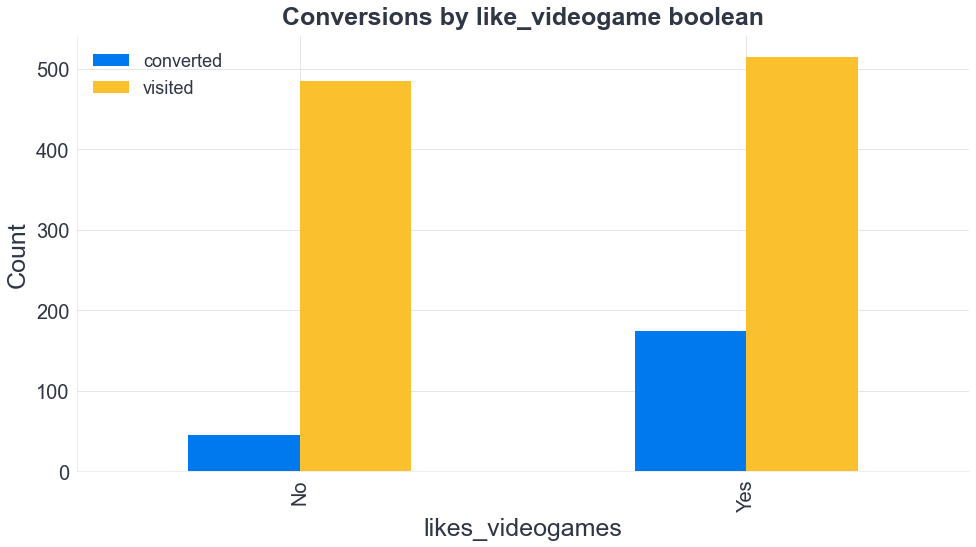

In [9]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.set_title("Conversions by like_videogame boolean")
ax.set_label("Count Conversion")
ax.set_ylabel("Count")
customers_table_summarized.plot(kind="bar", ax=ax);

ITs always a god idea to plot the results as well  just as as double check

## A/B Test in PyMC

In [10]:
visited = customers_table_summarized["visited"].to_numpy()
converted = customers_table_summarized["converted"].to_numpy()
coords = {"likes_videogames": customers_table_summarized.index}

with pm.Model(coords=coords) as ab_test:

    p_convert = pm.Beta("p_convert", 2, 2, dims="likes_videogames")
    pm.Binomial("obs", p=p_convert, n=visited, observed=converted)

    idata_likes_video_games = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_convert]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


We're not quite sure how to AB test in Bambi so for now we just use PyMC. Luckily the model is quite small so its quick to code up. Because we summed Everything here should look familiar to you


## Let's verify our sampling

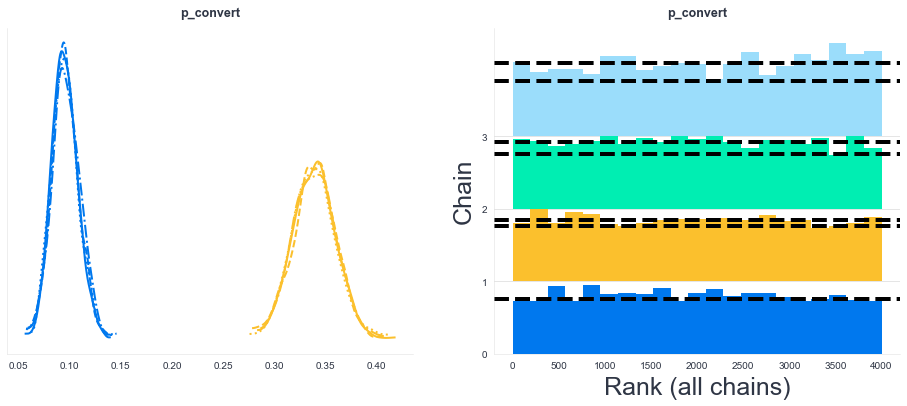

In [11]:
az.plot_trace(idata_likes_video_games, kind="rank_bars", figsize=(16,6));

Our sampling looks good, and we can already see from the KDE estimate that theres a big difference between the two groups

## Comparing the two groups

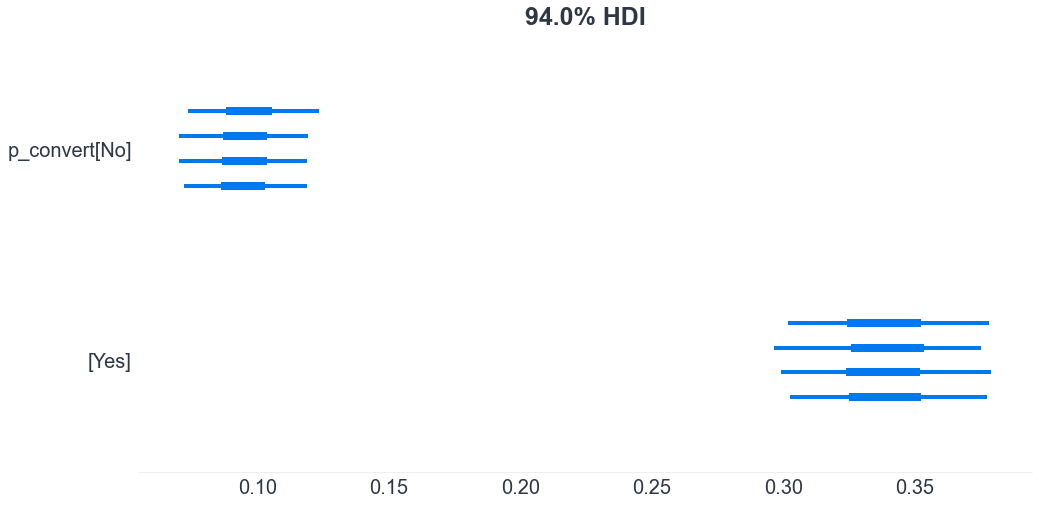

In [12]:
az.plot_forest(idata_likes_video_games, figsize=(16,8));

Great, were now very sure that there's a difference. 

## Section Recap
* Our boss asked us to analyze the probability of customer converting
* Our data includes
  * Whether people like video games
  * Age
* Wrote a Bayesian AB Test to show a credible difference in conversion due to video game preference

# Incorporating age
How continuity makes things hard

## Showing your boss the results

### *Well that was obvious, of course people that like videogames purchase more*

### *Why didn't you include age? How does that affect things?*

### *And Hurry up! I have a meeting with the CEO soon*

## Unfortunately we've only worked with discrete data

In [13]:
customers_table["likes_videogames"]

0       No
1      Yes
2       No
3       No
4      Yes
      ... 
995    Yes
996     No
997    Yes
998     No
999     No
Name: likes_videogames, Length: 1000, dtype: object

Our framework only works with discrete values that are either one value or another

## How do work with a continuous attribute?

In [14]:
customers_table["age"]

0      41.0
1      39.0
2      27.0
3      18.0
4      30.0
       ... 
995    35.0
996    23.0
997    47.0
998    27.0
999    54.0
Name: age, Length: 1000, dtype: float64

We need to figure out how to work with a continuous attribute like age

## A, B, C, D, E Comparison


In [15]:
customers_table["age_buckets"] = pd.cut(customers_table["age"], bins=5)
customers_table

,age,likes_videogames,converted,likes_videogames_bool,converted_bool,age_buckets
0,41.0,No,No,0,0,"(34.4, 42.6]"
1,39.0,Yes,Yes,1,1,"(34.4, 42.6]"
2,27.0,No,No,0,0,"(26.2, 34.4]"
3,18.0,No,No,0,0,"(17.959, 26.2]"
4,30.0,Yes,Yes,1,1,"(26.2, 34.4]"
...,...,...,...,...,...,...
995,35.0,Yes,No,1,0,"(34.4, 42.6]"
996,23.0,No,Yes,0,1,"(17.959, 26.2]"
997,47.0,Yes,No,1,0,"(42.6, 50.8]"
998,27.0,No,Yes,0,1,"(26.2, 34.4]"


One thing we could do is split the continuous variable into groups, which makes it discrete

## Summarizing the our derived buckets

In [16]:
customers_table_summarized = (customers_table.groupby("age_buckets")
    .agg(
        converted = ("converted_bool", sum),
        visited = ("converted_bool", len)
    )
)
customers_table_summarized

,converted,visited
age_buckets,,
"(17.959, 26.2]",95,193
"(26.2, 34.4]",65,204
"(34.4, 42.6]",36,195
"(42.6, 50.8]",20,194
"(50.8, 59.0]",3,214


To make things easier to see lets summarize this into a smaller dataframe as well. Even without statistical analysis we're seeing some trends. Lets dig in further

## Another quick EDA

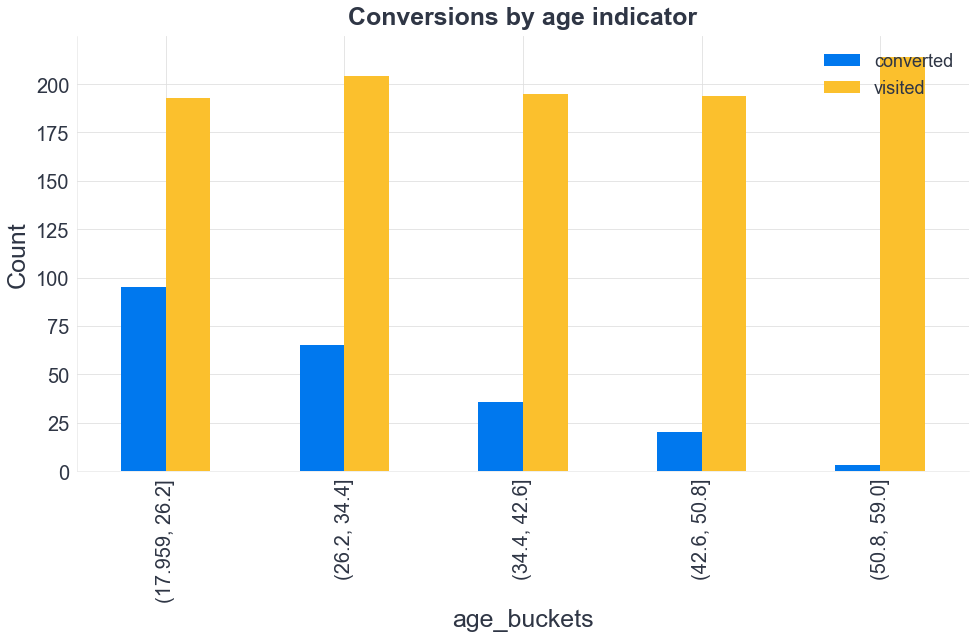

In [17]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.set_title("Conversions by age indicator")
ax.set_label("Count Conversion")
ax.set_ylabel("Count")
customers_table_summarized.plot(kind="bar", ax=ax);

## Our bucketed model

In [18]:
coords = {"age_buckets": customers_table_summarized.index}
num_customers = customers_table_summarized["visited"].to_numpy()
customers_converted = customers_table_summarized["converted"].to_numpy()

with pm.Model(coords=coords) as ab_test:
    p_convert = pm.Beta("p_convert", 2, 2, dims=("age_buckets"))
    
    obs = pm.Binomial("obs", p=p_convert,
                      n=num_customers,
                      observed=customers_converted)
    
    idata_buckets = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_convert]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Lets run sampling again. Notice how we changed the coords

## Checking sampling

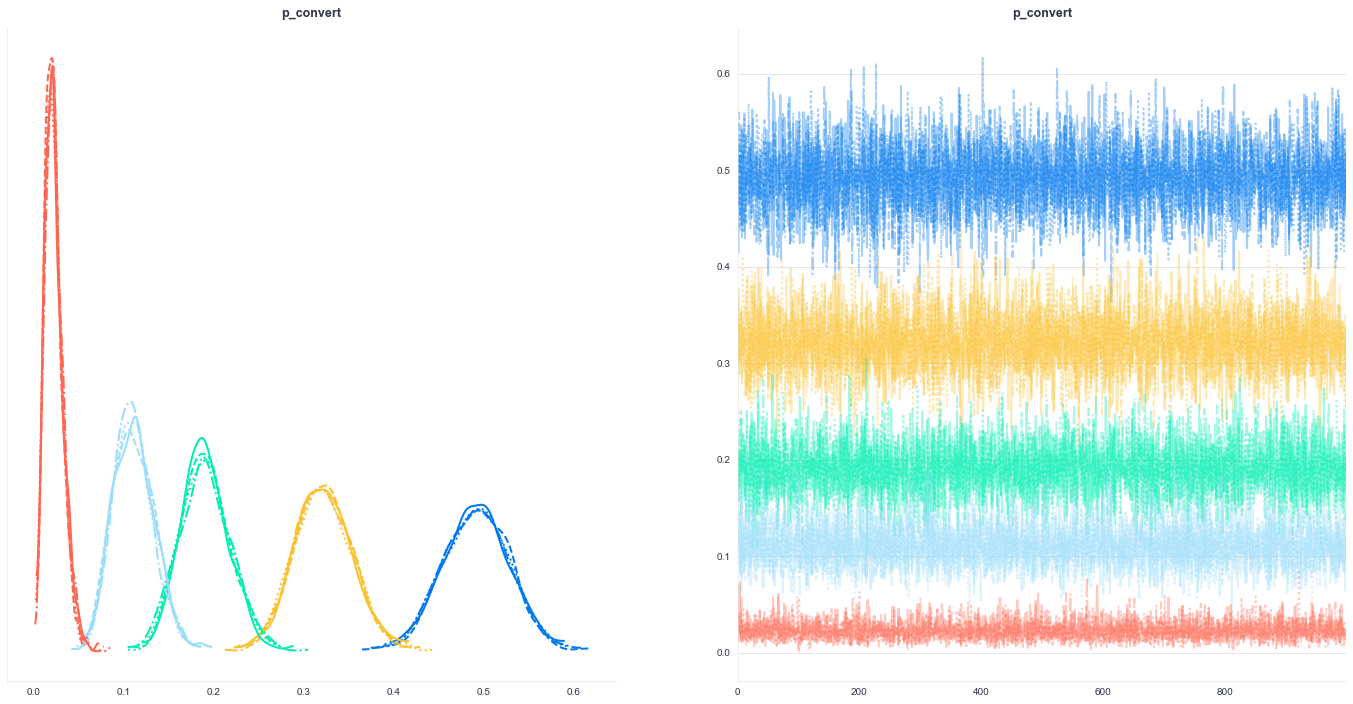

In [19]:
az.plot_trace(idata_buckets, figsize=(24, 12));

Now we can see something going on, but this doesn't exactly answer our question of how age relates to conversion directly. We can compare group to group but our boss specifically wants to know exactly how the percentage conversion drops by age.

## Comparing our age groups

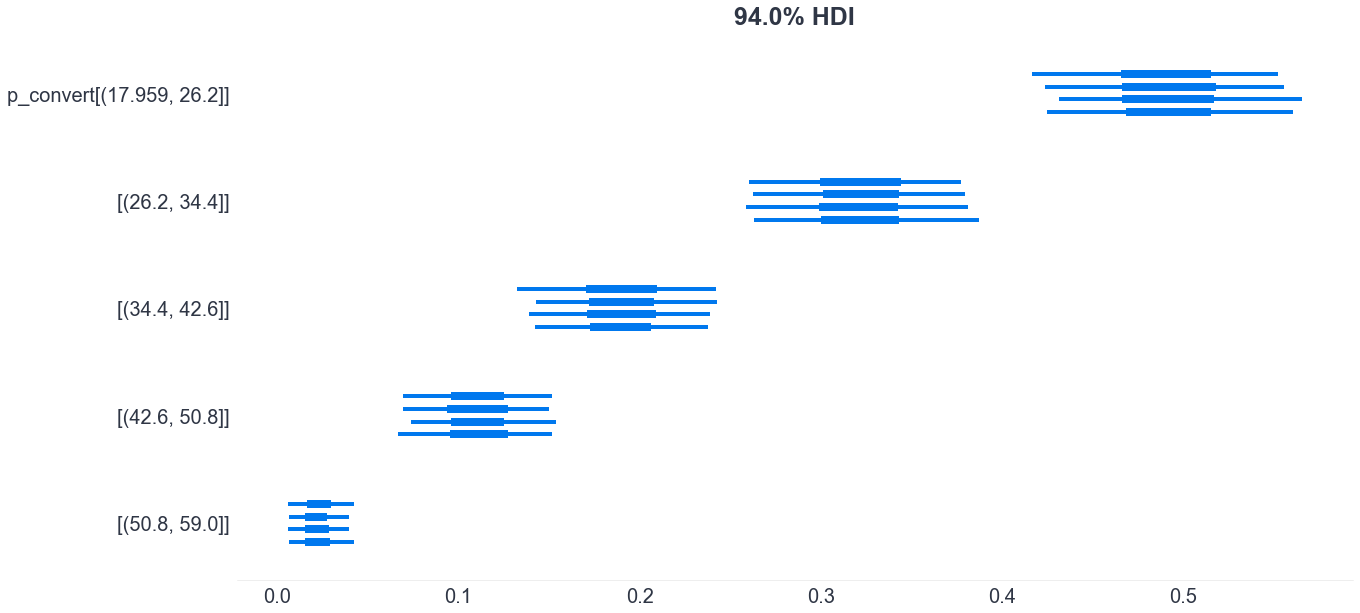

In [20]:
az.plot_forest(idata_buckets, var_names=["p_convert"], figsize=(20,10));

## But wait, we know regression!

In [21]:
converted_bool = df["converted_bool"].to_numpy()

with pm.Model() as ab_test:
    sigma = pm.Normal("p_convert", .001)
    β = pm.Normal("β", 0, .001, size=2)
    
    mu = pm.Deterministic("p", β[0] + β[1]*df["age"].to_numpy())
    
    # Switch to Bernoulli because we're predicting individual observations
    obs = pm.Bernoulli("obs", p=mu, observed=converted_bool)

If we take this to the logical extreme we could  plot conversion by age, but since conversion is just 0 or 1 we get this plot. How do we get a covariate for slope?

Note, potentially call this out as a difference between prior lessons to ensure its a learning point

## Lets try sampling

In [22]:
with ab_test:
    idata_age_reg = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'p_convert': array(0.38542932), 'β': array([0.84157794, 0.4928297 ])}

Initial evaluation results:
{'p_convert': -0.99, 'β': -475555.3, 'obs': -inf}

Ugh we're running into sampler issues. Looking at the error we see some things about negative p_convert but we don't ahve time for this

## Forget Bayes. Go back to OLS

In [23]:
import statsmodels.formula.api as smf
results = smf.ols('converted_bool ~ age', data=df).fit()
results.params

Intercept    0.759068
age         -0.013966
dtype: float64

We obviously see a trend related to age though and we want to use regression. Our Bayesian regression isn't working so lets just go to statsmodel and use ordinary least squares. 

And look we immediately get an answer. The probability of conversion drop 1% for every year 
Check it out, now we know the prob of conversion across our observed values

Lets go tell our boss!

## Regression problems

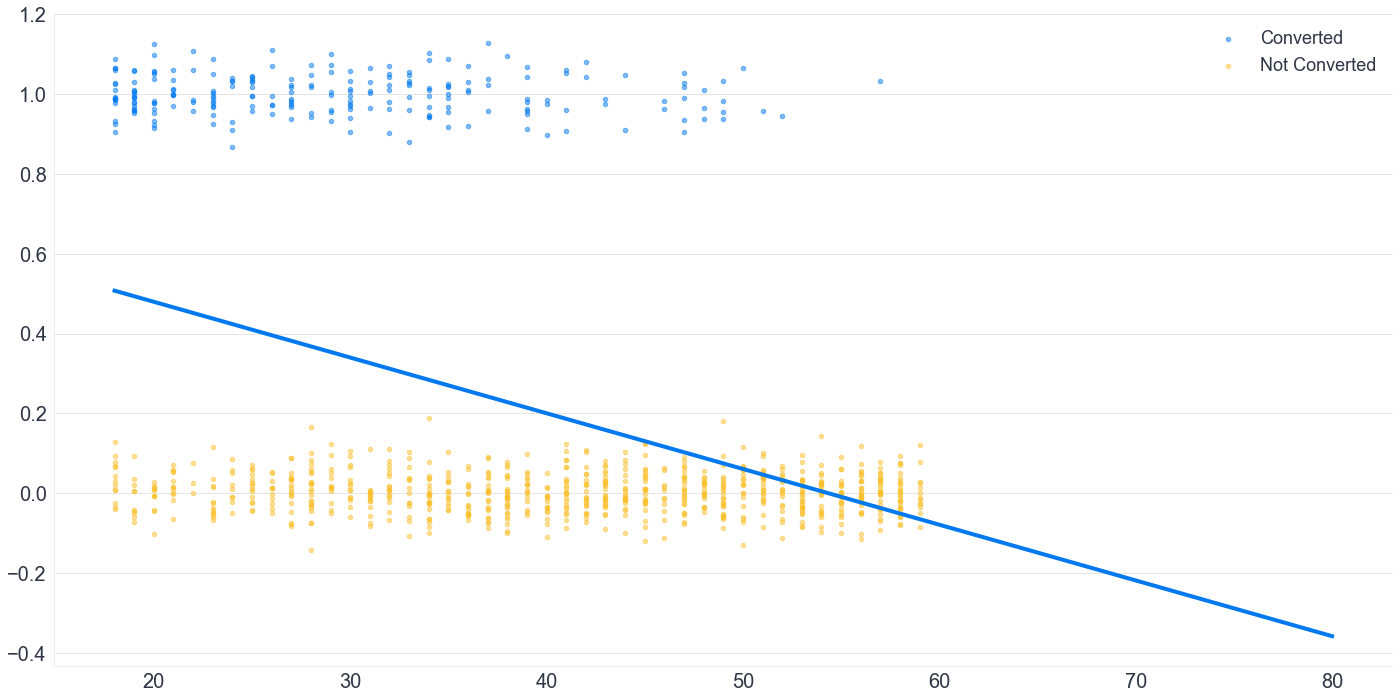

In [61]:
fig, ax = plt.subplots(figsize=(24,12))

converted_filter = df["converted_bool"].astype(bool)
# Add some jitter

jittered_y = df["converted_bool"] + stats.norm(scale=.05).rvs(df.shape[0])

alpha = .5
ax.scatter(df.loc[converted_filter, "age"],
          jittered_y[converted_filter],
          label="Converted",
          alpha=alpha,
           s=80)

ax.scatter( df.loc[~converted_filter, "age"],
           jittered_y[~converted_filter],
           label="Not Converted",
           alpha=alpha,
           s=80)


age_x = np.linspace(df["age"].min(), 80, 1000 )
y_pred = results.params[0] + results.params[1]*age_x
ax.plot(age_x, y_pred)
ax.legend();

But before we do lets just double check out plot. 
Negative probability? This is why our sampler was failing, it was telling us something
Oh man if we had reported these results we would have been fired
But look at the age of 60, something seems off?


## Section Recap
* Traditional AB Testing framework relies on discrete variables
* We tried converted a continuous variable into a discrete one 
  * Doesn't directly answer our question though
* Regression didn't work
  * Ordinary least squares produced a non sensical answer
  * Bayesian linear regression totally failed
  * An advantage of modern Bayesian frameworks is they "tell you" when something is wrong

# Section 40: Link Functions
The most important concept of this course

## Statistics and math review
* Probability is 0 1 bounded
* Linear regression is not

That's a problem if we're trying to estimate probability with regression

Linear regression will 
What if we can remap our observed to be between 0 and 1?


Turns out we you already know how. Remember our log transformation in the last lesson? What if we can apply a transformation?

## Sigmoid transformation
$$ \large
S(x) = \frac{1}{1 + e^{-x}} = \frac{e^x}{e^x + 1}
$$



This is also called
* Logistic 
* Expit 
* Logistic Sigmoid

Here's what it looks like in math. Note this is also called any one of the three things listed here.

## Plotting the Sigmoid function

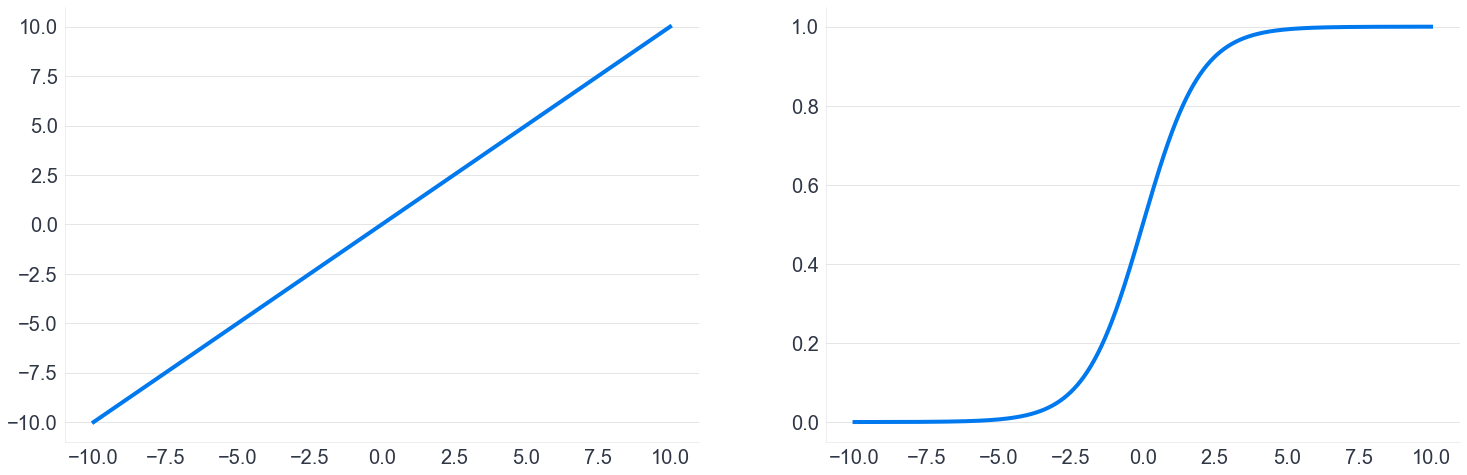

In [25]:
x = np.linspace(-10, 10, 1000)
y = x
transformed_y = 1/(1+np.exp(-x))

fig, axes = plt.subplots(1,2, figsize=(25,8))
axes[0].plot(x, y)
axes[1].plot(x, transformed_y);

And here's what it looks like in code

**Note** We will switch this to an animation to make it more clear what's happening

## Logistic Regression in PyMC

In [26]:
converted_bool = df["converted_bool"].to_numpy()

with pm.Model() as ab_test:
    
    # This is all the same linear regression as before
    sigma = pm.Normal("p_convert", 1)
    β = pm.Normal("β", 0, 1, size=2)
    
    mu = pm.Deterministic("mu", β[0] + β[1]*df["age"])
    
    # Our is our new sigmoid transformation
    p = pm.Deterministic("p", pm.math.sigmoid(mu))
    
    # Switch to Bernoulli because we're predicting individual observations
    obs = pm.Bernoulli("obs", p=p, observed=converted_bool)
    idata_sigmoid = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_convert, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Let's take our sigmoid transformation and add it into our model. We'll wrap it in pm.Deterministic so we can review the output later

## Inspecting our modeling results

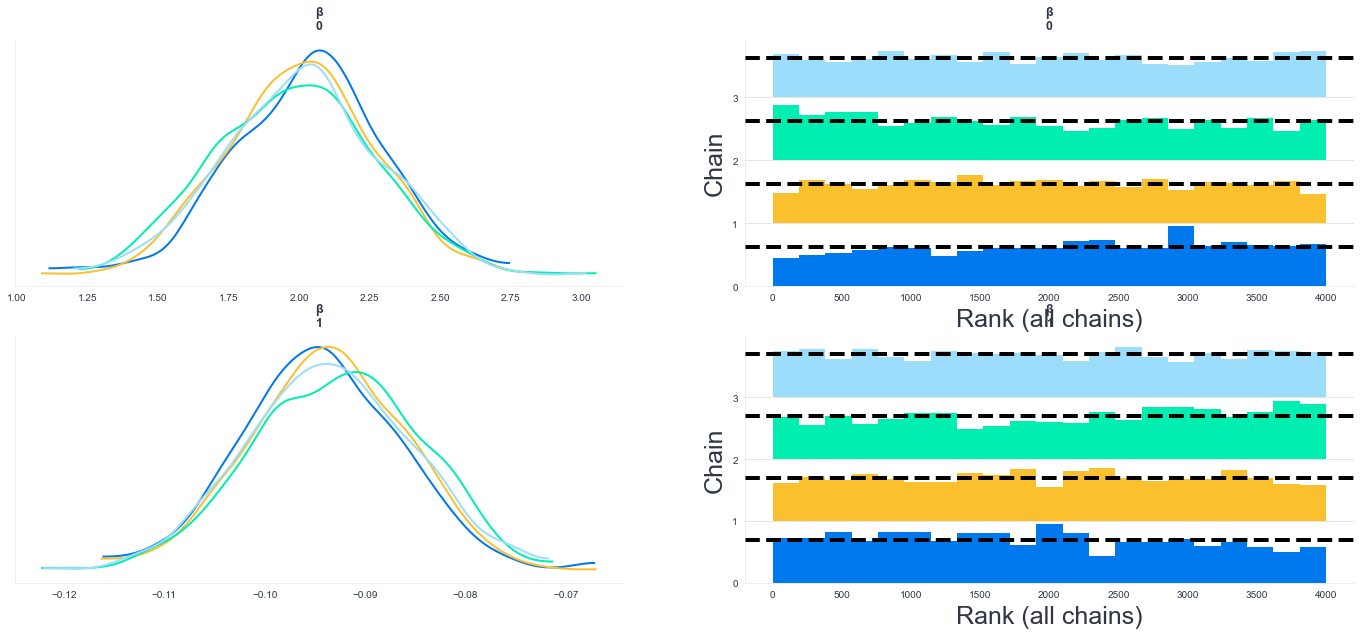

In [27]:
az.plot_trace(idata_sigmoid, var_names=["β"], compact=False, kind="rank_bars", figsize=(24, 10));

As always we'll be good Bayesians and review the model results before moving on

## Estimates of the results

In [28]:
az.summary(idata_sigmoid, var_names=["β"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β[0],2.007,0.273,1.493,2.519,0.006,0.004,1871.0,1875.0,1.0
β[1],-0.094,0.008,-0.108,-0.078,0.000,0.000,1829.0,1935.0,1.0


## This is the generalized linear model


$$
g(\mu_i) = \eta_i = \mathbf{x}_i^T\mathbf{\beta}
$$

We took an ordinary linear regression, and how we've generalized it. Its typically notated as this

G is the the **link function** in this case sigmoid.

You're going to see other versions of this in the upcoming lesson

## Generalized Linear models and Link functions in Bambi

In [32]:
model = bmb.Model("converted[Yes] ~ age", df, family="bernoulli", link="logit")
idata = model.fit(draws=2000, target_accept=0.85, random_seed=SEED)
az.summary(idata)

Modeling the probability that converted==Yes
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, age]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.163,0.279,1.654,2.707,0.004,0.003,4521.0,4616.0,1.0
age,-0.098,0.008,-0.114,-0.082,0.000,0.000,3809.0,4301.0,1.0


Turns out we can and surprise we get the same answer as the PyMC Model but with way less code. This is awesome


## Section Recap
* Transformations are the tool that turns linear regression into generalized linear equations
* Typically these are referred to as link functions 
* In our AB testing case the logit link function compressed our outputs into the 0 1 range
  * Also called the Sigmoid transformation

# End to End Analysis with Bambi 
From start to finish in our favorite model builder

## Single boolean covariate regression

In [33]:
model = bmb.Model("converted['Yes'] ~ likes_videogames+0", df, link="logit", family="bernoulli")
idata = model.fit(draws=2000, target_accept=0.85, random_seed=SEED)
az.summary(idata)

Modeling the probability that converted==Yes
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likes_videogames]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
likes_videogames[No],-2.288,0.159,-2.586,-1.988,0.002,0.001,8614.0,5593.0,1.0
likes_videogames[Yes],-0.673,0.094,-0.854,-0.502,0.001,0.001,8098.0,5810.0,1.0


Here's how we calculate the difference in behavior between folk that like videogames and those that don't. In this case we'll skip the diagnostics for brevity.

What we're looking for here is the 

## A ridge plot

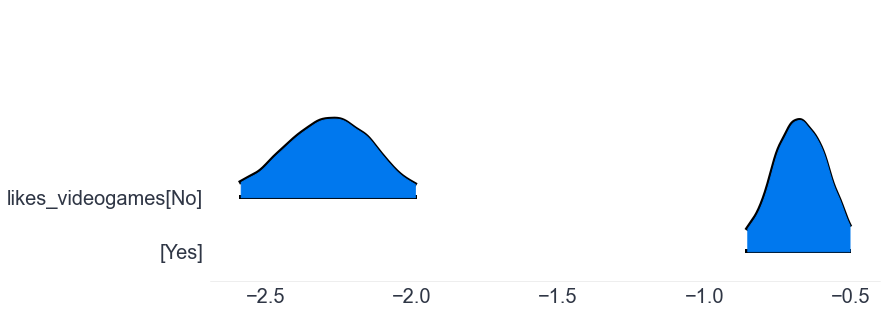

In [34]:
az.plot_forest(idata, var_names = ["likes_videogames"], kind="ridgeplot", combined=True);

This time we make a ridgeplot which indeed shows there a pretty big difference

## Convert to probability

In [35]:
special.expit(az.summary(idata)["mean"])

likes_videogames[No]     0.092122
likes_videogames[Yes]    0.337825
Name: mean, dtype: float64

Now check this out. If we want to convert to probability we run the output of our regression through the logistic/expit function.

Do these numbers look familiar? that's because its the exact same thing as our first AB Test. When we transform the means we end up with our original probabilities. How cool is that?

## Lets fit on age and A infinite testing

In [36]:
model = bmb.Model("converted['Yes'] ~ age", df, link="logit", family="bernoulli")
idata = model.fit(draws=2000, target_accept=0.85, random_seed=SEED)
az.summary(idata)

Modeling the probability that converted==Yes
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, age]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.163,0.279,1.654,2.707,0.004,0.003,4521.0,4616.0,1.0
age,-0.098,0.008,-0.114,-0.082,0.000,0.000,3809.0,4301.0,1.0


## The logistic regression result

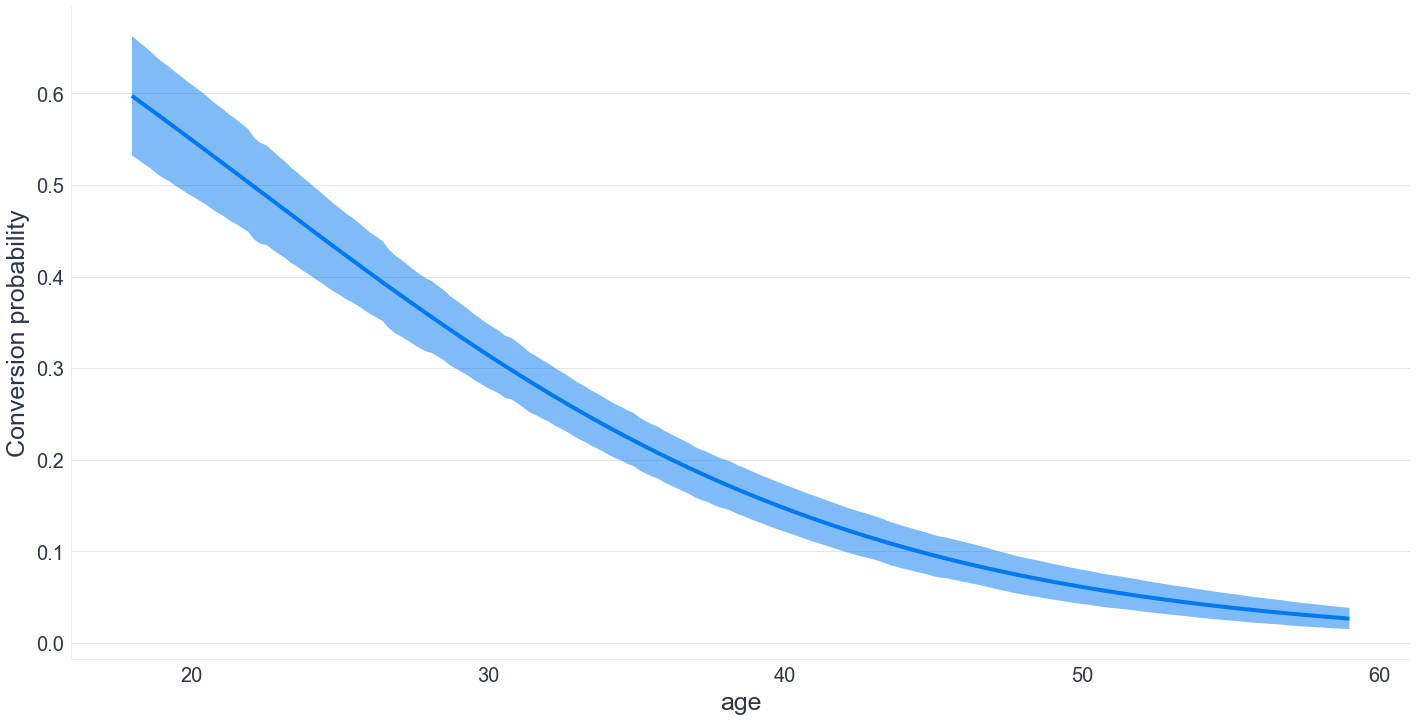

In [62]:
fig, ax = plt.subplots(figsize=(24, 12))
plots.plot_cap(model, idata, ["age"], ax=ax)
ax.set(ylabel="Conversion probability");

Check this out! We have the answer for our boss. As age increase prob decrease by this much.

This is basically A infinite testing because we have the p value as an INFINITE amount of ages along the x range. How freaking cool is that?

## Lets fit on age and likes videogames


In [38]:
model_age_videogames = bmb.Model("converted['Yes'] ~ age + likes_videogames", df, link="logit", family="bernoulli")
idata_age_videogames = model_age_videogames.fit(draws=2000, target_accept=0.85, random_seed=SEED)
az.summary(idata)

Modeling the probability that converted==Yes
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, age, likes_videogames]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 18 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.163,0.279,1.654,2.707,0.004,0.003,4521.0,4616.0,1.0
age,-0.098,0.008,-0.114,-0.082,0.000,0.000,3809.0,4301.0,1.0
converted_mean[0],0.597,0.034,0.532,0.662,0.000,0.000,5796.0,5634.0,1.0
converted_mean[1],0.592,0.034,0.528,0.657,0.000,0.000,5824.0,5656.0,1.0
converted_mean[2],0.588,0.034,0.523,0.651,0.000,0.000,5854.0,5594.0,1.0
...,...,...,...,...,...,...,...,...,...
converted_mean[195],0.029,0.007,0.017,0.041,0.000,0.000,3441.0,3893.0,1.0
converted_mean[196],0.028,0.006,0.016,0.040,0.000,0.000,3442.0,3893.0,1.0
converted_mean[197],0.028,0.006,0.016,0.040,0.000,0.000,3443.0,3893.0,1.0
converted_mean[198],0.027,0.006,0.015,0.039,0.000,0.000,3444.0,3904.0,1.0


## Age and Videogame plot

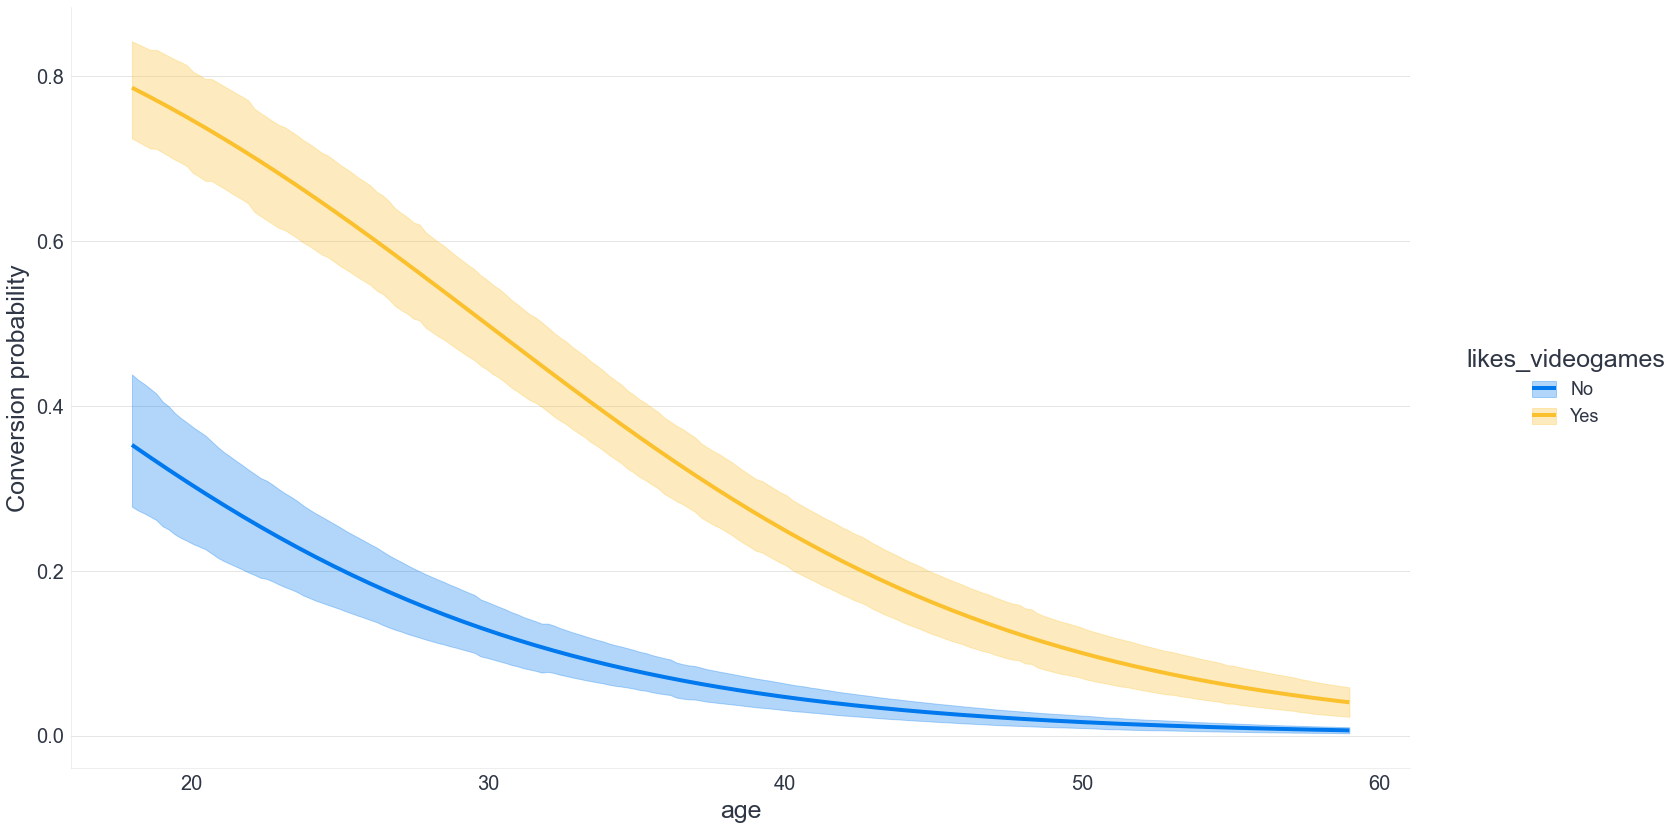

In [64]:
fig, ax = plt.subplots(figsize=(24, 14))
plots.plot_cap(model_age_videogames, idata_age_videogames, ["age", "likes_videogames"], ax=ax)
ax.set(ylabel="Conversion probability");

Holy crap guys this result is truly mindblowing. Not only do we know the prob at every age. When we control for whether people like videogames or not we see a totally different trend.

Now when you go talk to your boss you not only provided the age insight, but you can recommend who to target per age and preference. And with this intuitive plot your boss is sure to give you a rise!

## Making a prediction

In [40]:
df_predict = pd.DataFrame({"age": [20, 30, 40], "likes_videogames":["No","Yes", "Yes"]})
predictions = model.predict(idata, data=df_predict, inplace=False, kind="pps")
predictions.posterior_predictive.mean(["chain", "draw"])["converted"]

<xarray.DataArray 'converted' (converted_dim_0: 3)>
array([0.543   , 0.314875, 0.142375])
Coordinates:
  * converted_dim_0  (converted_dim_0) int64 0 1 2

Check this out
Turns out a 20 year old will convert at 20 percent rate, even if they dont like videogames, which is less than 30 year old that does like video games, and about the same as a 40 year old that likes videogames!

Now if any new customer comes in we can predict their prob conversion

## Section Recap
* AB testing is equivalent to categorical regression
  * The categories are our groups
* Bambi makes logistic regression quite easy to build regression with multiple covariates
  * In this case age and videogame preference
* `plot_cap` helps us easily visualize continuous results
  * Gives us the answer for probability of conversion with age
  * Since this is regression we can even control for preference quite easily
  * Can easily discern the differing trend in conversion between the two groups
* Predictions are quite easy to generate as well

# Logistic Regression in practice
United States Election Modeling

## Voter preference for candidates

<center>
  <img src="img/presidential-election-background_1057-1753.jpg" style="height:850px"; />
</center>

We're going to be modeling voters self reported preferences for voting for either Hilary Clinton or Donald Trump. Now  we're going to put politics aside and focus on the statistics

## Election Dataset

In [41]:
data = bmb.load_data("ANES")
data

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican
...,...,...,...
416,trump,46,independent
417,clinton,64,democrat
418,someone_else,31,independent
419,clinton,39,democrat


The ANES is a nationally representative, cross-sectional survey used extensively in political science. This is a dataset from the 2016 pilot study, consisting of responses from 1200 voting-age U.S. citizens.

https://electionstudies.org/data-center/anes-2016-pilot-study/

## Summary Statistics

In [42]:
data = data.loc[data["vote"].isin(["clinton", "trump"]), :]
data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


## Party Preference and Age

In [43]:
model_age = bmb.Model("vote[clinton] ~ party_id + scale(age)", data, family="bernoulli")
model_age.build()
model_age

Formula: vote[clinton] ~ party_id + scale(age)
Family name: Bernoulli
Link: logit
Observations: 373
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 3.2871)
    party_id ~ Normal(mu: [0. 0.], sigma: [5.4007 6.0634])
    scale(age) ~ Normal(mu: 0.0, sigma: 2.5)

And one trick we didn't show, you don't even need to specify the link function as Bambi can default it

## Model Graph View

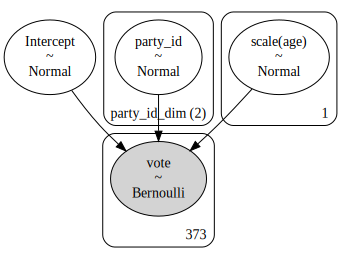

In [44]:
model_age.graph()

## Sampling

In [45]:
inf_data_age = model_age.fit(draws = 2000, tune = 2000)

Modeling the probability that vote==clinton
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, party_id, scale(age)]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 19 seconds.


In [46]:
az.summary(inf_data_age, var_names=["party_id", "scale(age)"], kind="stats")

,mean,sd,hdi_3%,hdi_97%
party_id[independent],-2.522,0.325,-3.120,-1.907
party_id[republican],-5.066,0.539,-6.135,-4.116
scale(age),-0.358,0.149,-0.636,-0.086


## Create a new dataset with age going from 18 to 90

In [47]:
age = np.arange(18, 91)
parties = ["democrat", "republican", "independent"]
new_data = pd.DataFrame({
    "age": np.tile(age, 3),
    "party_id": np.repeat(parties, len(age))
})
new_data

,age,party_id
0,18,democrat
1,19,democrat
2,20,democrat
3,21,democrat
4,22,democrat
...,...,...
214,86,independent
215,87,independent
216,88,independent
217,89,independent


## Define Prediction Machine

In [48]:
def make_vote_predictions(model, idata):

    # Predict mean of P(vote = clinton | age) by plugging in new data
    model.predict(idata, data=new_data)

    # Compute mean across chains
    posterior_mean = idata.posterior["vote_mean"].values.mean(0)

    # Select 500 draws
    # Transpose to get an array of shape (219, 500)
    posterior_mean = posterior_mean[:500, :].T
    return posterior_mean

posterior_mean = make_vote_predictions(model_age, inf_data_age)

## Plot our predictions

In [69]:
from matplotlib.lines import Line2D


def plot_vote_predictions(posterior_mean, ax):

    for i, party in enumerate(parties):
        idx = new_data.index[new_data["party_id"] == party]
        ax.plot(age, posterior_mean[idx], alpha=0.05, color=f"C{i}")

    ax.axhline(y = 0, ls="--", color="#a3a3a3", zorder=1)
    ax.axhline(y = 1, ls="--", color="#a3a3a3", zorder=1)
    ax.set_ylabel("P(vote=clinton | age)")
    ax.set_xlabel("Age", fontsize=25)
    ax.set_ylim(-0.025, 1.025)
    ax.set_xlim(18, 90)

    fig.subplots_adjust(top=0.925, left=0.1, right=0.95, bottom=0.1)

    labels = [party.capitalize() for party in parties]

    # Create legend
    handles = [
        Line2D(
            [0], [0], label=label, marker="o", color="None", 
            markerfacecolor=f"C{i}", markeredgewidth=0, markersize=10
        )
        for i, label in enumerate(labels)
    ]

    # Add legend
    x_center = 0.1 + (0.95 - 0.1) / 2 
    legend = fig.legend(
        handles=handles, 
        ncol=5,
        loc="lower center",
        bbox_to_anchor=(x_center, 0.925),
        handletextpad=0.2,
        columnspacing=2,
        fontsize=25,
    )

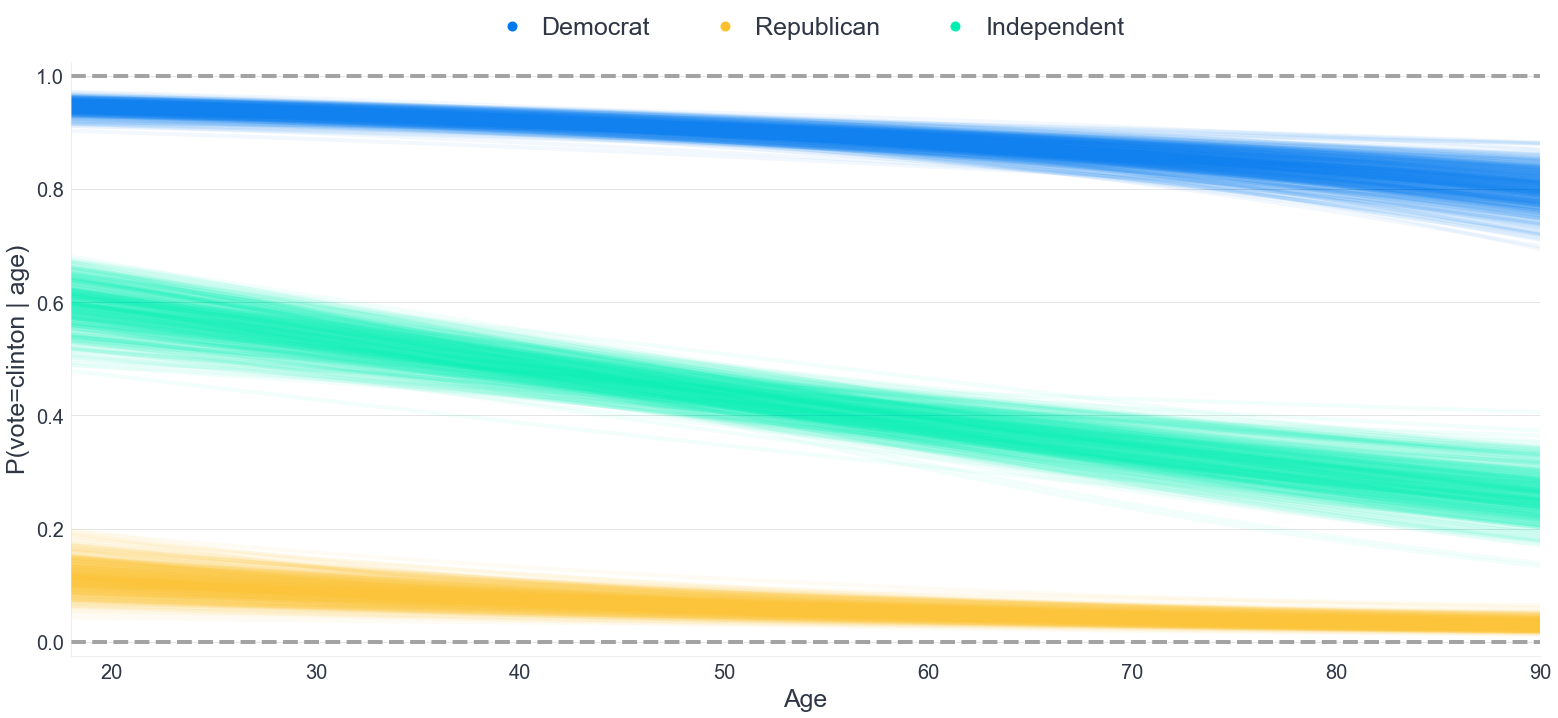

In [71]:
fig, ax = plt.subplots(figsize=(24, 10))

posterior_mean = make_vote_predictions(model_age, inf_data_age)
plot_vote_predictions(posterior_mean, ax=ax)

Now this is interesting. We can see that obvious patterns. People that are Republican tend to vote for Trump, folks that are democrat vote for Clinton, and modeates are about 50/50. But age seems to be a factor. Across all age groups the number of votes declines

## Voting Age Interaction Model

In [51]:
model_age_interaction = bmb.Model("vote[clinton] ~ party_id + party_id:scale(age)", data, family="bernoulli")
idata_age_interaction = model_age_interaction.fit(draws = 2000, tune = 2000)

Modeling the probability that vote==clinton
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, party_id, party_id:scale(age)]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 22 seconds.


Now we're going to rerun our analysis and do something subtle here. We'll change the party_id categorical indicator to have an interaction with age.

## Model graph with the interaction term

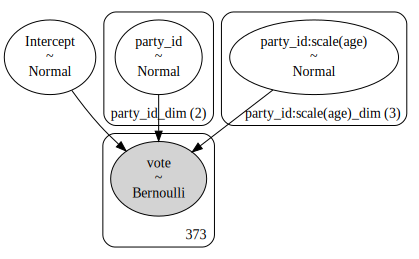

In [52]:
model_age_interaction.graph()

You can see that on the top right with dim(3) indicating we now have 3 extra covariates in our model

## Our Age  estimates

In [53]:
az.summary(idata_age_interaction, kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,2.310,0.266,1.797,2.795
party_id[independent],-2.557,0.330,-3.174,-1.951
party_id[republican],-5.730,0.784,-7.197,-4.303
party_id:scale(age)[democrat],0.216,0.259,-0.262,0.700
party_id:scale(age)[independent],-0.578,0.205,-0.952,-0.187
party_id:scale(age)[republican],-1.439,0.688,-2.735,-0.177


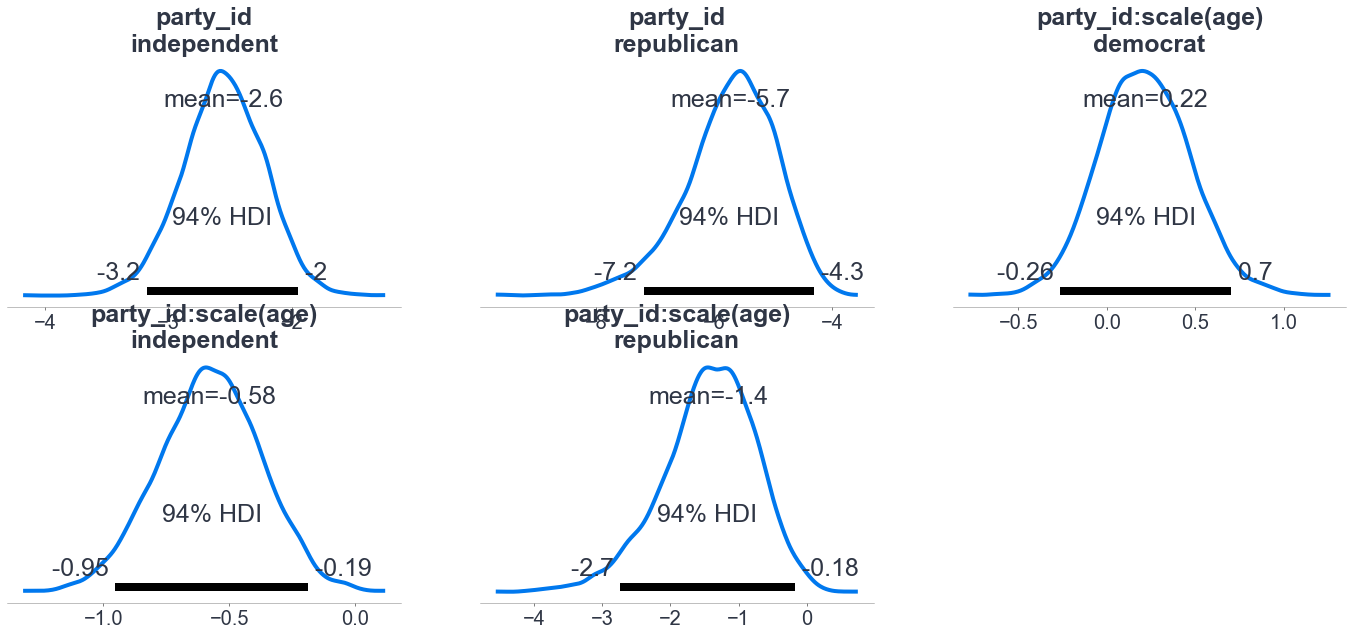

In [54]:
# Note this is skipped in the presentation asi ts broken
az.plot_posterior(idata_age_interaction, var_names=["party_id", "party_id:scale(age)"], figsize=(24,10));

Now we can again see 3 variables for each our interactions. Lets make the same plot again

## Plotting our age interaction

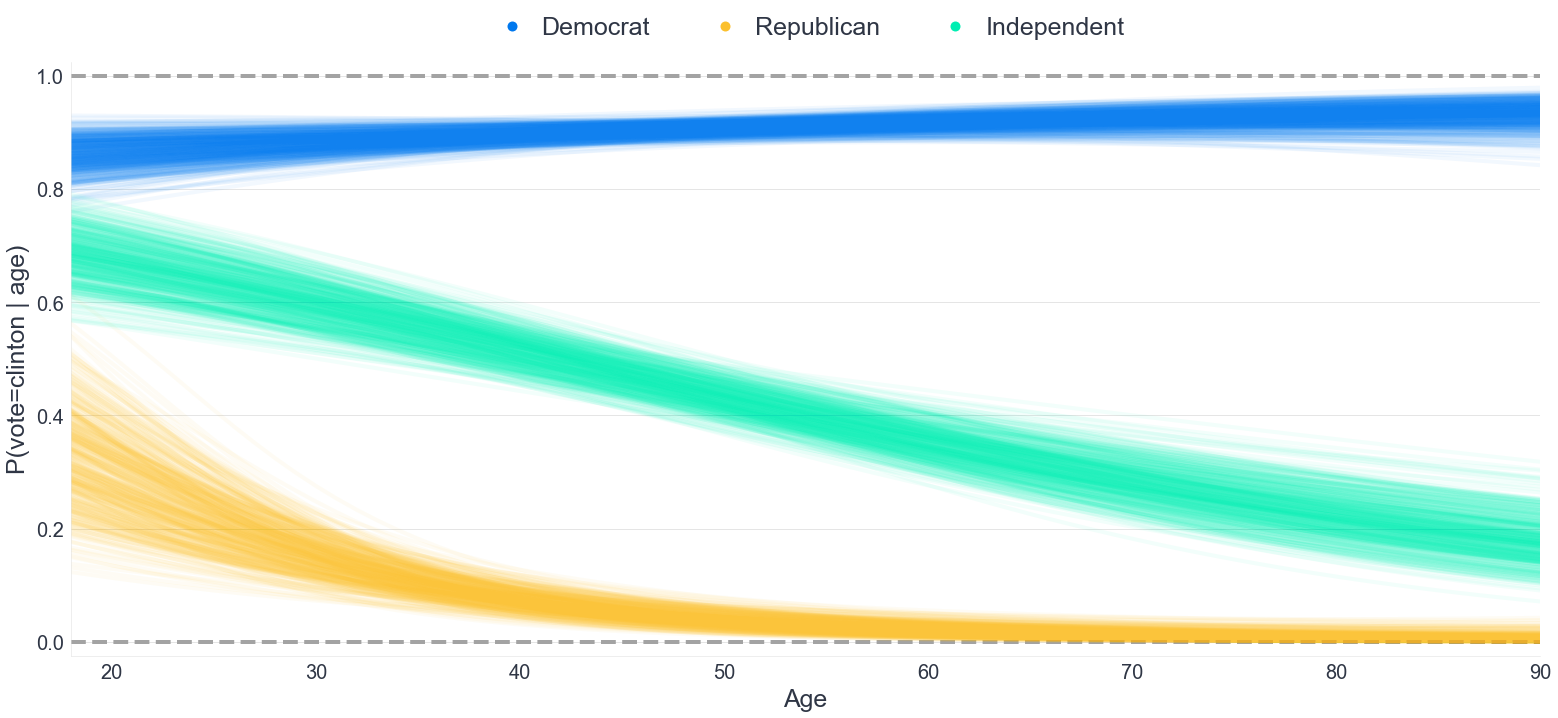

In [73]:
fig, ax = plt.subplots(figsize=(24, 10))

posterior_mean = make_vote_predictions(model_age_interaction, idata_age_interaction)
plot_vote_predictions(posterior_mean, ax=ax)

Now we see something different! As people who identify with a party age they tend to **generally** be more sure of their candidate. With Republican voters the trend is clear, they vote for Trump. For democrat voters they tend to vote for Clinton more on average, but it seems there is a but more uncertainary

And on the young end we see even more variability for republican voters than we did in the previous graph.

Which regression is right? They both are! One represents age on average, the previous one. And this one tells the story of age once we control for party preference. 

## Bambi functions make generalized linear models easy

<center>
  <img src="img/Bambi_logo.png" style="height:900"; />
</center>

The good news is that with Bambi makes generalized linear models easy and fast. We can quickly go from linear model idea to results, to plots in minutes. Our old boss at the videogame store would be proud.

## Section Recap
* Logistic Regression can help us understand voter preferences
* Interaction effects help us answer different questions
  * How does propensity to vote for one candidate or another?
  * How does it change per subgroup?
* Plotting many posterior predictive samples helps us understand variability

# Lesson Recap
Will fill in after rest of notebook is approved

# Appendix Section: Binomial Model
Reviewer's note: This section would be recorded
If we'd rather prefer binomial heres how todo it.

## DataFrame at individual level

In [56]:
df

,age,likes_videogames,likes_videogames_bool,p_convert,converted_bool,converted
631,18.0,No,0,0.310026,0,No
852,18.0,No,0,0.310026,0,No
926,18.0,Yes,1,0.768525,1,Yes
302,18.0,No,0,0.310026,0,No
50,18.0,No,0,0.310026,1,Yes
...,...,...,...,...,...,...
472,59.0,No,0,0.007392,0,No
396,59.0,No,0,0.007392,0,No
409,59.0,No,0,0.007392,0,No
281,59.0,Yes,1,0.052154,0,No


## Aggregate to (Converted, Count)

In [57]:
(
    df
    .groupby(["likes_videogames", "age"])
    .agg(
        Converted = ("converted_bool", sum),
        Count = ("converted_bool", len)
    )
    .reset_index()
)

,likes_videogames,age,Converted,Count
0,No,18.0,6,16
1,No,19.0,3,10
2,No,20.0,2,9
3,No,21.0,3,6
4,No,22.0,2,4
...,...,...,...,...
79,Yes,55.0,0,9
80,Yes,56.0,0,14
81,Yes,57.0,1,12
82,Yes,58.0,0,10


In [58]:
binom_df = (df
    .groupby(["likes_videogames", "age"])
    .agg(
        Converted = ("converted_bool", sum),
        Count = ("converted_bool", len)
    )
    .reset_index()
)
binom_df

,likes_videogames,age,Converted,Count
0,No,18.0,6,16
1,No,19.0,3,10
2,No,20.0,2,9
3,No,21.0,3,6
4,No,22.0,2,4
...,...,...,...,...
79,Yes,55.0,0,9
80,Yes,56.0,0,14
81,Yes,57.0,1,12
82,Yes,58.0,0,10


In [59]:
conversion_model = bmb.Model("p(Converted, Count) ~ likes_videogames + age", binom_df, family="binomial")
conversion_model_fitted = conversion_model.fit(draws=2000, target_accept=0.85, random_seed=SEED)

TypeError: 'TensorVariable' object is not callable

In [ ]:
az.summary(conversion_model_fitted)

In [ ]:
conversion_model = bmb.Model("p(Converted, Count) ~ likes_videogames + age", binom_df, family="binomial")
conversion_model_fitted = conversion_model.fit(draws=2000, target_accept=0.85, random_seed=SEED)